## Imports, Macros & Helper Functions

In [ ]:
PROBLEM_NAME = 'swap_keys_values'
index = 6
BASE_DIR = f'{index}_{PROBLEM_NAME}/'
# '1_first_num_greater_than', '2_remove_extras', '3_num_smaller', '4_sort_age', '5_top_k', '6_swap_keys_values'
CODE_DIR = f'{index}_{PROBLEM_NAME}/codes'

In [2]:
import re
import os
import sys
import csv
import json
import openai
import shutil
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import scipy.cluster.hierarchy as sch 
from sentence_transformers import SentenceTransformer, util

from distance import ted_dist, rougelcsum_dist
from run_all_tests import *
importlib.reload(sys.modules['run_all_tests'])

openai.api_key = "ENTER YOUR OWN"

In [3]:
# for directories that doesn't exist yet, create them
LLMCODE_DIR = f'{CODE_DIR}/llm_code/'
BUGGY_DIR = f'{CODE_DIR}/llm_buggy/'
SYNTAXERR_DIR = f'{CODE_DIR}/llm_syntaxerr/'
CORRECT_DIR = f'{CODE_DIR}/llm_correct/'
STUDENTBUG_DIR = f'{CODE_DIR}/student_buggy/'
STUDENT_DIR = f'{CODE_DIR}/student_submissions/'
FIXED_DIR = f'{CODE_DIR}/fixed_code/'

for directory in [LLMCODE_DIR, BUGGY_DIR, SYNTAXERR_DIR, CORRECT_DIR, STUDENTBUG_DIR, STUDENT_DIR, FIXED_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

with open(f"{BASE_DIR}description.txt", "r") as f:
    PROBLEM_DESCRIPTION = f.read()

In [4]:
testcase_hint_file = BASE_DIR+'testcase_hint.csv'
testgroup_file = BASE_DIR+'testgroup.txt'

expl_label_file = BASE_DIR+'generated_expl_label.csv'
splitted_expl_file = BASE_DIR+'generated_expl_splitted.csv'
distractor_file = BASE_DIR+'distractor_selected_ev_threshold=0.9.csv'
distractor_hint_file = BASE_DIR+'distractor_selected_tchint.csv'

fixed_code_r1_file = BASE_DIR+'splitted_expl_fixed_code_round1.csv'
fixed_code_r2_file = BASE_DIR+'splitted_expl_fixed_code_round2.csv'

In [5]:
def write_to_json(json_obj, file_name="gpt_responses.json"):
    file = f"{BASE_DIR}{file_name}"
    if not os.path.exists(file): # create file not exist and write empty list
        with open(file , 'w+') as f:
            json.dump([], f)
    with open(file) as f:
        json_list = json.load(f)
        json_list.append(json_obj) # need to be not a dict
    with open(file, 'w') as f:
        json.dump(json_list, f, separators=(',', ': '), indent=4)
    return 

# write response object to file with prompt + temperature, and return response & text
def submit_gpt(prompt, task, max_attempts=3, temp=0.3, model="gpt-3.5-turbo"):
    for i in range(max_attempts):
        try: 
            response = openai.ChatCompletion.create(
                model=model,
                messages=prompt,
                temperature=temp,
                stop=["###"],
            )
            text = response['choices'][0]['message']['content'].strip()
            stop = response['choices'][0]['finish_reason']
            print(f'======= Attemp #{i}\n{text}')
            if (stop == "stop" and text != "" and "\nassert" not in text):
                response["prompt"] = prompt
                response["temperature"] = temp
                response["task"] = f"{task}_{i}_SUCCESS"
                write_to_json(response)
                return response, text
            else:
                print(f'failed to return attemp #{i}\n', stop, "\nassert" in text)
                response["task"] = f"{task}_{i}_FAILED"
                write_to_json(response)
        except Exception as e:
            print(f'openai request failed at attemp #{i}\n{e}')
    return None, None

def get_sorted_py(directory):
    py_names, py_contents = [], dict()
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".py"):
            py_names.append(filename)
            py_contents[filename] = open(f"{directory}{filename}", "r").read()
    return py_names, py_contents

In [6]:
def get_function_header():
    with open(f"{BASE_DIR}refsol.py", "r") as f:
        for line in f.readlines():
            if line.startswith("def"):
                header = line.strip()+"\n\t"
                print("function header: ", header)
                return header

PROBLEM_FIRST_LINE = get_function_header()

def get_refsol_output(inputs_filename='inputs.txt'):
    return run_file(BASE_DIR, BASE_DIR, 'refsol.py', PROBLEM_NAME, inputs_filename)
refsol_outputs = get_refsol_output()

function header:  def swap_keys_values(d):
	
*** Testing implementation refsol.py ***
*** Module *** ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'swap_keys_values'] 6_swap_keys_values.refsol swap_keys_values
{}
{'a': '1'}
{'a': '1', 'b': '2', 'c': '3', 'd': '4'}
{'a': '3', 'b': '2'}
{'a': '3'}


# 1. Pre-generate buggy codes for instruction (GPT3.5)

## Helper function

In [7]:
def classify_single_code(code_name, code_dir, f=PROBLEM_NAME, input_dir=BASE_DIR):
    code_out = run_file(input_dir, code_dir, code_name, f)
    allPassed = True
    if len(code_out) != len(refsol_outputs): # syntax error
        return None
    for i in range(len(code_out)):
        if code_out[i] != refsol_outputs[i]:
            print(f"{refsol_outputs[i]}\t!=\t{code_out[i]}")
            allPassed = False
    return allPassed

def move_single_code(code):
    allPassed = classify_single_code(code, LLMCODE_DIR)
    if allPassed is None:
        shutil.move(os.path.join(LLMCODE_DIR, code), os.path.join(SYNTAXERR_DIR, code))
    elif allPassed == True:
        print("All passed!")
        shutil.move(os.path.join(LLMCODE_DIR, code), os.path.join(CORRECT_DIR, code))
    else:
        print("Some failed!")
        shutil.move(os.path.join(LLMCODE_DIR, code), os.path.join(BUGGY_DIR, code))
    return allPassed

# classify buggy/correct & remove exact duplicates
def classify_buggy_correct():
    codes, _ = get_sorted_py(LLMCODE_DIR)
    for code in codes:
        move_single_code(code)

In [8]:
def remove_duplicate_codes(directory=BUGGY_DIR):
    codes = dict()
    counts, dup_counts = 0, 0
    code_names, code_files = get_sorted_py(directory)
    for code_name in code_names:
        counts += 1
        code = code_files[code_name]
        if code in codes:
            dup_counts += 1
            os.remove(os.path.join(directory, code_name))
        else:
            codes[code] = code_name
    print(f"Removed {dup_counts} duplicate codes out of {counts} total codes in {directory}")
    return codes

pymarkdown_regex = re.compile("```python\n([^`]*)\n```")
def find_all_python_markdown(text, code_name, regex=pymarkdown_regex):
    correct_dict = remove_duplicate_codes(CORRECT_DIR)
    buggy_dict = remove_duplicate_codes(BUGGY_DIR)
    match_all = regex.findall(text)
    matches = set(match_all)
    print(f"Found {len(match_all)} python code blocks ({len(matches)} unique) in {code_name}")
    dup_buggy, dup_correct = 0, 0
    for i, m in enumerate(matches):
        code = m.strip()
        if len(code) > 0:
            if code in correct_dict:
                dup_correct += 1
            elif code in buggy_dict:
                dup_buggy += 1
            else:
                timestamp = code_name.split(".py")[0]
                filename = f"{timestamp}_{i}.py"
                with open(LLMCODE_DIR+filename, "w") as f:
                    f.write(code)
                is_correct = move_single_code(filename)
                if is_correct is not None:
                    if is_correct: correct_dict[code] = code_name
                    else: buggy_dict[code] = code_name
                    
    print(f"Found {dup_correct} duplicate correct codes and {dup_buggy} duplicate buggy codes in {code_name}")

In [9]:
def generate_buggy_code_prompt():
    instruction = "Write different buggy solutions with common mistakes like novice students.\n\n"
    return [ 
        {"role": "system", "content": 
          "You are a novice student in intro CS, you make mistakes and write buggy code when solving a problem."}
        , {"role": "user", 
          "content": "### Problem Description: \n" + PROBLEM_DESCRIPTION 
            + "\n\n### Instruction: " + instruction
            + f"### Buggy Implementations: \n\n" 
            }
       ]

def get_code_gpt(num_experiments=20, max_attempts=3, temp=0.7):
    prompt = generate_buggy_code_prompt()
    task = "generate_buggy_code"
    for _ in range(num_experiments):
      response, text = submit_gpt(prompt, task, max_attempts, temp)
      if text is not None:
        code_name = f'{response.created}'
        find_all_python_markdown(text, code_name)

In [ ]:
### Experiment:
# get_code_gpt(num_experiments=15)

## Cluster buggy codes & test cases 
generate output tables; visualize HAC & calculate distance scores

### Helper function

In [ ]:
def special_str(out):
    if out == '\t': return "tab"
    else: return str(out)
        
def format_outputs(outputs, refsol_outputs, delimiter='\t'):
    return delimiter.join([special_str(outputs[i]) if refsol_outputs[i] != outputs[i] else "pass" for i in range(len(outputs))])

def format_filenames(subject_id=""):
    SUBJECT_INPUT = f'inputs.txt'
    SUBJECT_OUTPUT = f'{BASE_DIR}outputs{subject_id}.tsv'
    INPUTS = [inp for inp in get_inputs_from_file(BASE_DIR+SUBJECT_INPUT)]
    return SUBJECT_INPUT, SUBJECT_OUTPUT, INPUTS

def write_to_output(ALL_BUGGY_DIR=BUGGY_DIR, source="gpt", subject_id=""):
    SUBJECT_INPUT, SUBJECT_OUTPUT, INPUTS = format_filenames(subject_id)
    refsol_outputs = get_refsol_output(SUBJECT_INPUT)
    with open(SUBJECT_OUTPUT, 'w') as f:
        # column names: [dirname, filename, for each inp in inputs.txt]
        print('source\tfilename\t' + '\t'.join(INPUTS),file=f)
        print('instructor\trefsol.py\t' + '\t'.join([special_str(out) for out in refsol_outputs]), file=f)
        codes, code_content = get_sorted_py(ALL_BUGGY_DIR)
        for code in codes:
            print(code, code_content[code])
            outputs = run_file(BASE_DIR, ALL_BUGGY_DIR, code, PROBLEM_NAME, SUBJECT_INPUT)
            print(f"{source}\t{code}\t{format_outputs(outputs, refsol_outputs)}", file=f)
    print(f"*** Evaluated {subject_id}'s {len(INPUTS)} inputs on {len(codes)} buggy codes ***")
    return SUBJECT_OUTPUT, INPUTS

# OUT, INP = write_to_output(subject_id="_gpt")

In [11]:
def get_binary_matrix(df, remove_dup=True, remove_binary_dup=False):
    if remove_dup:
        df = df.drop_duplicates(subset=INP, keep='first')
        print("# unique buggy codes", df.shape[0]-1)
    binary_unique = df.iloc[:, 2:].apply(lambda x: (x == 'pass'), axis=0)
    binary_unique.iloc[0] = True # change the row refsol to all True
    binary_unique = binary_unique.apply(lambda x: x.astype(int), axis=0)
    if remove_binary_dup: 
        binary_unique = binary_unique.drop_duplicates()
        print("# unique binary buggy codes", binary_unique.shape[0]-1)
    return binary_unique

def add_filename_source(df, binary):
    binary_unique = binary.copy()
    binary_unique[['source', 'filename']] = df[['source', 'filename']]
    return binary_unique

def format_testcase_vs_buggycode():
    # INP = [inp for inp in get_inputs_from_file(BASE_DIR+"inputs.txt")]
    GPT_OUTPUT = f'{BASE_DIR}outputs_gpt.tsv'
    data_ref = pd.read_csv(GPT_OUTPUT, sep='\t')
    print("Total codes for", PROBLEM_NAME, ":", data_ref.shape[0]-1)
    binary_matrix = get_binary_matrix(data_ref, remove_dup=True, remove_binary_dup=True)
    binary_ref = add_filename_source(data_ref, binary_matrix)

    # transpose matrix with header using the "filename" column map to the index
    trans_ref = binary_matrix.T
    filenames_list = list(binary_ref['filename'])
    testcases_list = list(trans_ref.index)
    print(len(filenames_list), "code files: ", filenames_list)
    print(len(testcases_list), "test cases: ", testcases_list)
    trans_ref.columns = filenames_list
    return binary_matrix, trans_ref, testcases_list, filenames_list, binary_ref

# binary_matrix, trans_ref, testcases_list, filenames_list, binary_ref = format_testcase_vs_buggycode()

## Vizualize HAC helper function

In [13]:
def map_color_source(map_dict):
    color_map = dict()
    for _, file in binary_ref.iterrows():
        color_map[file["filename"]] = map_dict[file['source']]
    return color_map


def create_dendro_fig(ax, X, label, method='average', font_size=10, color_threshold=2.3, color_label=False):
    # Create linkage, method='average', 'ward', 'complete', 'single'; metric="jaccard", "euclidean"
    Z = sch.linkage(X, method=method, metric="euclidean", optimal_ordering=True)
    sch.set_link_color_palette(['red', '#34eb34', 'blue', '#ae34eb'])
    sch.dendrogram(Z, ax=ax, leaf_rotation=80, leaf_font_size=font_size, labels=label, 
                color_threshold=color_threshold, above_threshold_color='black')
    ax.axhline(y=color_threshold, c='grey', lw=1, linestyle='dashed')
    ax.set_title(f'Clustering for {PROBLEM_NAME}, method={method}')
    if color_label: label_color(ax)
    # plt.show()

def label_color(ax):
    gpt_map = {"instructor": "black", "student": "red", "gpt": "blue"}
    copilot_map = {"instructor": "black", "student": "red", "copilot": "blue"}
    colorDict = map_color_source(gpt_map)
    # ax = plt.gca()
    x_labels = ax.get_xmajorticklabels()
    for x in x_labels:
            x.set_color(colorDict[x.get_text()])

Text(0.5, 0, 'Buggy codes Dendrogram')

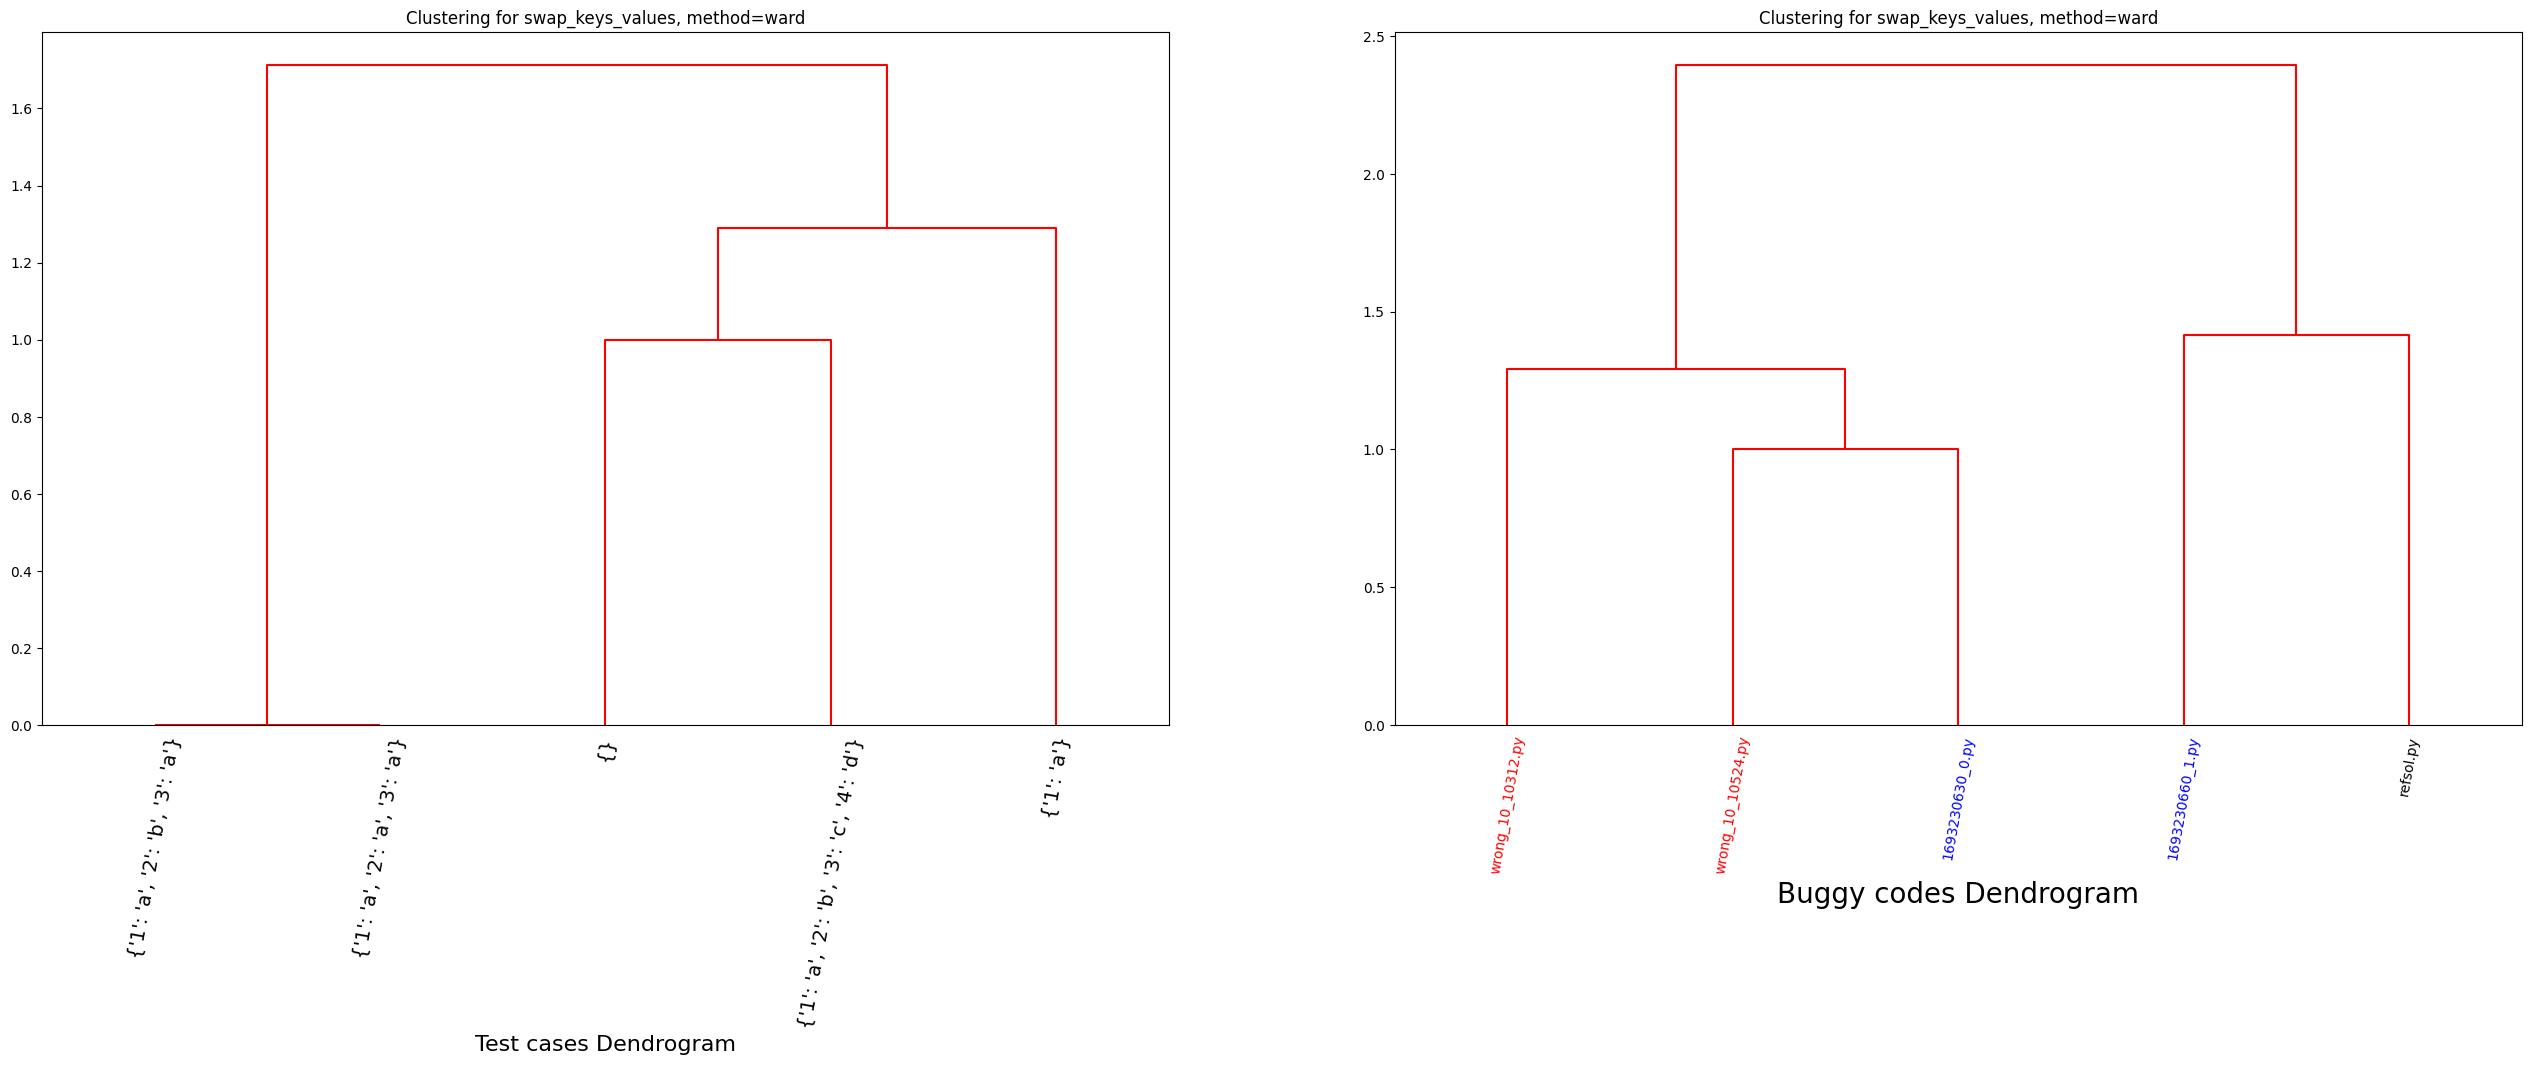

In [ ]:
def create_dendro_testcase_buggycode():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32,9))
    create_dendro_fig(ax1, trans_ref, testcases_list, method='ward', font_size=14, color_threshold=2.8)
    create_dendro_fig(ax2, binary_matrix, label=filenames_list, method='ward', color_threshold=3, color_label=True)
    ax1.set_xlabel('Test cases Dendrogram', fontsize=16)
    ax2.set_xlabel('Buggy codes Dendrogram', fontsize=20)

## Prep: Calculate distance between test cases & buggy codes

In [14]:
def get_pair_dist(matrix, label_list, metric='euclidean'):
    dist = pairwise_distances(matrix, metric=metric, n_jobs=-1)
    print(dist.shape, len(label_list))
    return dist

# produce a distance matrix for buggy code using self-specified distance metric
def get_matrix_dist(label_list, buggy_code_dict, metric="ted"):
    dist = np.zeros((len(label_list), len(label_list)))
    for i in range(len(label_list)):
        for j in range(len(label_list)):
            if metric == "ted": # buggy_code_dict
                dist[i][j] = ted_dist(buggy_code_dict[label_list[i]], buggy_code_dict[label_list[j]])
            elif metric == "rougelcsum":
                dist[i][j] = rougelcsum_dist(buggy_code_dict[label_list[i]], buggy_code_dict[label_list[j]])
    print(metric, dist.shape, len(label_list))
    return dist

def get_max_dist_ncodes(label, buggycode_list, dist_matrix, n = 3):
    max_dist, max_dist_codes = 0, []
    for codes in itertools.combinations(buggycode_list, n):
        dist = 0
        for pairs in itertools.combinations(codes, 2):
            dist += dist_matrix[buggycode_list.index(pairs[0])][buggycode_list.index(pairs[1])]
        dist /= n
        if dist > max_dist:
            max_dist = dist
            max_dist_codes = codes

    print(label, max_dist, max_dist_codes)
    return max_dist_codes

In [ ]:
# buggycode_list = filenames_list[1:] # get rid of refsol
# buggycode_dist = get_pair_dist(binary_matrix[1:].values, buggycode_list)
# testcase_dist = get_pair_dist(trans_ref.values, testcases_list)
# max_dist_codes = get_max_dist_ncodes("EV:", buggycode_list, buggycode_dist)

(4, 4) 4
(10, 10) 10
(5, 5) 5
EV: 0.9428090415820635 ('1693230630_0.py', '1693230634_0.py', '1693230660_1.py')


In [ ]:
def sort_by_mindist(buggycode_dist_df, n=2):
    dist_col_names = ["distance" + str(i) for i in range(1, n+1)]
    code_col_names = ["similar_code_name" + str(i) for i in range(1, n+1)]
    col_names = ["buggy_code_name"] + [val for pair in zip(dist_col_names, code_col_names) for val in pair]

    buggycode_mindist = pd.DataFrame(buggycode_dist_df[buggycode_dist_df > 0].apply(lambda x: pd.Series(x.nsmallest(n).values, index=dist_col_names), axis=1))
    buggycode_mindist[code_col_names] = buggycode_dist_df[buggycode_dist_df > 0].apply(lambda x: pd.Series(x.nsmallest(n).index, index=code_col_names), axis=1)
    buggycode_mindist["buggy_code_name"] = buggycode_mindist.index
    buggycode_mindist.reset_index(drop=True, inplace=True)
    buggycode_mindist = buggycode_mindist[col_names]
    return buggycode_mindist

def order_mindist_codes(dist_matrix=buggycode_dist, n=10):
    buggycode_dist_df = pd.DataFrame(dist_matrix, index=buggycode_list, columns=buggycode_list)
    buggycode_mindist = sort_by_mindist(buggycode_dist_df, n)
    return buggycode_mindist

# buggycode_mindist = order_mindist_codes() # buggycode_dist, ted_dist_matrix, rougeclsum_dist_matrix
# buggycode_mindist.head()

,buggy_code_name,distance1,similar_code_name1,distance2,similar_code_name2,distance3,similar_code_name3,distance4,similar_code_name4,distance5,...,distance6,similar_code_name6,distance7,similar_code_name7,distance8,similar_code_name8,distance9,similar_code_name9,distance10,similar_code_name10
0,1693230630_0.py,1.414214,1693230660_1.py,1.414214,1693230660_2.py,1.414214,1693230694_2.py,NaN,1693230630_0.py,NaN,...,NaN,1693230634_1.py,NaN,1693230660_0.py,NaN,1693230666_4.py,NaN,1693230707_0.py,NaN,1693230726_1.py
1,1693230634_0.py,1.414214,1693230660_1.py,1.414214,1693230660_2.py,1.414214,1693230694_2.py,NaN,1693230630_0.py,NaN,...,NaN,1693230634_1.py,NaN,1693230660_0.py,NaN,1693230666_4.py,NaN,1693230707_0.py,NaN,1693230726_1.py
2,1693230634_1.py,1.414214,1693230660_1.py,1.414214,1693230660_2.py,1.414214,1693230694_2.py,NaN,1693230630_0.py,NaN,...,NaN,1693230634_1.py,NaN,1693230660_0.py,NaN,1693230666_4.py,NaN,1693230707_0.py,NaN,1693230726_1.py
3,1693230660_0.py,1.414214,1693230660_1.py,1.414214,1693230660_2.py,1.414214,1693230694_2.py,NaN,1693230630_0.py,NaN,...,NaN,1693230634_1.py,NaN,1693230660_0.py,NaN,1693230666_4.py,NaN,1693230707_0.py,NaN,1693230726_1.py
4,1693230660_1.py,1.414214,1693230630_0.py,1.414214,1693230634_0.py,1.414214,1693230634_1.py,1.414214,1693230660_0.py,1.414214,...,1.414214,1693230707_0.py,1.414214,1693230726_1.py,NaN,1693230660_1.py,NaN,1693230660_2.py,NaN,1693230694_2.py


In [ ]:
# testcases_dist_df = pd.DataFrame(testcase_dist, index=testcases_list, columns=testcases_list)
# testcase_maxdist = pd.DataFrame(testcases_dist_df[testcases_dist_df > 0].idxmax(axis=1))
# testcase_maxdist.columns = ['most_diff_testcase']
# testcase_maxdist['distance'] = testcases_dist_df[testcases_dist_df > 0].max(axis=1).values
# testcase_maxdist.head()

,most_diff_testcase,distance
{},"{'1': 'a', '2': 'b', '3': 'a'}",1.414214
{'1': 'a'},{},1.000000
"{'1': 'a', '2': 'b', '3': 'c', '4': 'd'}",{},1.000000
"{'1': 'a', '2': 'b', '3': 'a'}",{},1.414214
"{'1': 'a', '2': 'a', '3': 'a'}",{},1.414214


# 2. Pre-generate explanations for buggy code (GPT4)

## Helper function

In [15]:
def expl_prompt(buggy_code, instruction):
    setup = [{'role': 'system', 'content': 'You are a helpful and experienced teaching assistant of an introductory programming class.'},
         {"role": "user", 
          "content": "Hi, I'm a student in your class. I'm having trouble with this problem in the programming assignment:\n\n" 
            + PROBLEM_DESCRIPTION 
            + "\n\nI've tried to fix my code but I'm still stuck. Can you help me?"} 
        , {"role": "assistant", "content": "Sure, let's take a look at your code."}
    ]
    question = [ {'role': 'user', 
    'content': f"Here's my buggy code:\n {buggy_code}\n" + instruction } 
    ]
    return setup + question 

def get_explanation(buggy_code, instruction, model, temp, max_attempts=2):
    prompt = expl_prompt(buggy_code, instruction)
    task = "explain_bug"
    response, text = submit_gpt(prompt, task, max_attempts, temp, model)
    return response.created, text

def get_all_buggy_expl(instruction, model="gpt-4", temp=0.3):
    materials = []
    code_names, code_files = get_sorted_py(BUGGY_DIR)
    for buggy_code_name in code_names:
        buggy_code = code_files[buggy_code_name]
        expl_id, text = get_explanation(buggy_code, instruction, model, temp)
        materials.append({'buggy_code_name': buggy_code_name, 'buggy_code': buggy_code, 
        'explanation_id': expl_id, 'explanation': text})
    return materials

prompt_precise_expl = """What's wrong with my code? List all the unique bugs included, but do not make up bugs. 
For each bullet point, put in the format of: 
- {explanation: accurate and concise explanation of what the code does and what the bug is, for a novice; fix: how to fix the bug, within 30 words} 
Only return the bullet list. Do not write any other text or code. 
"""

In [ ]:
lineexpl_regex3 = re.compile(r'\{explanation: (.+?)[;.] fix: (.+?)\}')

def get_buggy_codes_expl(file_name, expl_col="final_instruction"):
    with open(file_name, 'r') as f:
        df = pd.read_csv(f)
    df = df[["buggy_code_name", "buggy_code", expl_col]] 
    df.columns = ["buggy_code_name", "buggy_code", "buggy_code_expl"]
    return df

def extract_line_expl_fix(string, regex=lineexpl_regex3):
    lines = []
    for expl, fix in regex.findall(string): lines.append((expl, fix))
    if len(lines) == 0: print("No match found in: {}".format(string))
    return lines

def format_line(line):
    expl, fix = line
    return "{explanation: " +  f"{expl}; fix: {fix}" + "}", expl, fix

def split_multi_bug(labeled_file):
    gpt4_format_expl = get_buggy_codes_expl(labeled_file)
    gpt4_dict = gpt4_format_expl.to_dict('records')
    print("before splitting multi-bug", len(gpt4_dict))
    for row in gpt4_dict:
        if type(row['buggy_code_expl']) != str: print(row)
        lines = extract_line_expl_fix(row['buggy_code_expl'])
        # if the length of list n > 1, split the row into n rows, each with one explanation and the copy of buggy code
        if len(lines) > 1:
            fix_instruction, expl_instruction = "", ""
            for index, line in enumerate(lines):
                formated_line, expl, fix = format_line(line)
                fix_instruction += f"{fix}. "
                expl_instruction += f"{expl}. "
                new_row = {"buggy_code_name": row['buggy_code_name'][:-3] +f"_bug{index+1}" + ".py", "buggy_code": row['buggy_code'], 
                        "buggy_code_expl": formated_line, "expl_instruction": expl, "fix_instruction": fix}
                gpt4_dict.append(new_row)
            row['expl_instruction'], row['fix_instruction'] = expl_instruction.strip(), fix_instruction.strip()
        else: 
            assert len(lines) == 1
            row['buggy_code_expl'], row['expl_instruction'], row['fix_instruction']= format_line(lines[0])
    print("after splitting multi-bug", len(gpt4_dict))
    return pd.DataFrame(gpt4_dict)

In [ ]:
### Experiment
# materials = get_all_buggy_expl(prompt_precise_expl, model="gpt-4", temp=0.3)

# labels = ["multibug_correct", "expl_correct", "fix_correct", "final_instruction"]
# with open(expl_label_file, 'w') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=list(materials[0].keys())+labels)
#     writer.writeheader()
#     for data in materials: writer.writerow(data)

# gpt4_format_expl = split_multi_bug(expl_label_file)
# gpt4_format_expl.to_csv(splitted_expl_file, index=False)

# 3. Hint for test case & test category

## Helper function

In [16]:
def test_category_prompt(testcase): 
    return [ 
        {'role': 'system', 'content': 'You are a helpful and experienced teaching assistant of an introductory programming class.'},
        {"role": "user", "content": "Problem Description: \n" + PROBLEM_DESCRIPTION +
         f"Briefly describe this test case's input and explain what important aspect of this problem it covers:\n{testcase}\n"}
        ]

def tc_hint_prompt(tc_prompt, expl):
    return tc_prompt + [
        {"role": "assistant", "content": expl },
        {"role": "user", "content": "Reformat the explanation as a one-sentence hint. Use this template: Write a test case to cover the scenario where ..."},
    ]

def format_testcases():
    TESTCASES = []
    for (inp, out) in zip(INP, refsol_outputs):
        TESTCASES.append((inp, f"assert({PROBLEM_NAME}({inp}) == {out})"))
    return TESTCASES

def get_test_hint_gpt(max_attempts=2, temp=0.1):
    tclist = []
    for (test_input, testcase) in format_testcases():
        prompt = test_category_prompt(testcase) # test_input
        response, expl = submit_gpt(prompt, "explain_testcase", max_attempts, temp)
        assert expl is not None
        response, hint = submit_gpt(tc_hint_prompt(prompt, expl), "format_tc_hint", max_attempts, temp)
        assert hint is not None
        tclist.append({'tc': testcase, 'tc_hint_id': response.created, 'tc_expl': expl, 'tc_hint': hint})
    # write to csv: tc, tc_hint_id, tc_hint, most_diff_tc
    with open(testcase_hint_file, 'w') as f:
        writer = csv.DictWriter(f, fieldnames=['tc', 'tc_hint_id', 'tc_hint', 'tc_expl', 'tc_hint_correct', 'edited_tc_hint'])
        writer.writeheader()
        for tc in tclist: writer.writerow(tc)

def test_group_init_prompt():
    return [ 
        {'role': 'system', 'content': 'You are a helpful and experienced teaching assistant of an introductory programming class.'},
        {"role": "user", "content": "Problem Description: \n" + PROBLEM_DESCRIPTION +
         f"List three most important aspects of this problem that need to be tested by describing the type of input. Write only each aspect in 3-6 words \n"}
        ]

def get_test_group_gpt(max_attempts=2, temp=0.3):
    prompt = test_group_init_prompt()
    response, groups = submit_gpt(prompt, "init_testgroup", max_attempts, temp)
    assert groups is not None
    with open(testgroup_file, 'w') as f:
        f.write(str(groups))
    return groups

In [17]:
def extract_input(tc):
    # use regex to extract test_input from tc, which format as assert(PROBLEM_NAME({test_input}) == {expected_output})
    test_input = re.search(r'assert\(\w+\((.+)\) ==', tc).group(1)
    return test_input

def get_expl_fix_dict(filename=testcase_hint_file):
    with open(filename, 'r') as f: 
        df = pd.read_csv(f)
    return dict([(extract_input(tc), test_hint) for tc, test_hint in zip(df.tc, df.edited_tc_hint)])

# with open(BASE_DIR+"tests_hint.json", "w") as f:
#     json.dump(get_expl_fix_dict(), f, indent=4)

# 4. Select explanation distractors for every buggy code

In [18]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def calculate_sentence_similarity(s1, s2):
    embedding_1= model.encode(s1, convert_to_tensor=True)
    embedding_2 = model.encode(s2, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_1, embedding_2).item()

def get_splitted_expl(splitted_expl_file):
    with open(splitted_expl_file, 'r') as f: 
        df = pd.read_csv(f)
    df = df[["buggy_code_name", "buggy_code", "buggy_code_expl", "edited_expl_instruction"]] 
    df.columns = ["buggy_code_name", "buggy_code", "buggy_code_expl_fix", "expl_instruction"]
    return df

# After human annotation/validation, get expl_label_file
# df = pd.read_csv(expl_label_file)
# buggy_code_dict = dict(zip(df.buggy_code_name, df.buggy_code))
# expl_splitted = get_splitted_expl(splitted_expl_file)
# buggy_code_expl_dict = dict(zip(expl_splitted.buggy_code_name, expl_splitted.expl_instruction))

In [ ]:
def calculate_pairwise_expl_similarity(row, n=10, threshold=0.9):
    buggy_code_name = row["buggy_code_name"]
    expl_instruction = buggy_code_expl_dict[buggy_code_name]
    valid_distractors = []
    for i in range(1, n+1):
        similar_code_name = row[f"similar_code_name{i}"]
        similar_code_expl = buggy_code_expl_dict[similar_code_name]
        similarity = calculate_sentence_similarity(expl_instruction, similar_code_expl)
        if similarity > threshold: pass
        else:
            valid_distractors.append({"distractor_code_name": similar_code_name, 
                                      "distractor_nth_closest": i, 
                                      "distractor_code_distance": row[f"distance{i}"], 
                                      "distractor_expl": similar_code_expl, 
                                      "distractor_expl_similarity": similarity})
    
    if len(valid_distractors) < 2: print(f"!!! {len(valid_distractors)} valid distractors, too few or many for {buggy_code_name}")
    for (distractor1, distractor2) in itertools.combinations(valid_distractors, 2):
        distractor_similarity = calculate_sentence_similarity(distractor1["distractor_expl"], distractor2["distractor_expl"])
        if distractor_similarity > threshold: continue
        else:
            valid_distractors = [distractor1, distractor2]
            break

    row["buggy_code"] = buggy_code_dict[buggy_code_name]
    row["buggy_code_expl"] = expl_instruction
    row["distractor_similarity"] = distractor_similarity
    for i in [1, 2]:
        row[f"distractor_code_name{i}"] = valid_distractors[i-1]["distractor_code_name"]
        row[f"distractor_nth_closest{i}"] = valid_distractors[i-1]["distractor_nth_closest"]
        row[f'distractor_code{i}'] = buggy_code_dict[valid_distractors[i-1]["distractor_code_name"]]
        row[f"distractor_code_distance{i}"] = valid_distractors[i-1]["distractor_code_distance"]
        row[f"distractor_expl{i}"] = valid_distractors[i-1]["distractor_expl"]
        row[f"distractor_expl_similarity{i}"] = valid_distractors[i-1]["distractor_expl_similarity"]
    return row

# buggycode_mindist = order_mindist_codes()
# # filter selected buggy code by max_dist_codes
# selectedcode_mindist = buggycode_mindist[buggycode_mindist.buggy_code_name.isin(max_dist_codes)]
# distractors = selectedcode_mindist.apply(calculate_pairwise_expl_similarity, axis=1)
# distractors.head()

,buggy_code_name,distance1,similar_code_name1,distance2,similar_code_name2,distance3,similar_code_name3,distance4,similar_code_name4,distance5,...,distractor_code1,distractor_code_distance1,distractor_expl1,distractor_expl_similarity1,distractor_code_name2,distractor_nth_closest2,distractor_code2,distractor_code_distance2,distractor_expl2,distractor_expl_similarity2
0,1693174464_0.py,1.000000,1693174502_3.py,1.414214,1693174471_0.py,1.414214,1693174480_4.py,1.414214,1693174494_3.py,NaN,...,def sort_age(people):\n return sorted(peopl...,1.000000,Your code is trying to access the third elemen...,0.621276,1693174471_0.py,2,def sort_age(people):\n people.sort(key=lam...,1.414214,Your code is almost correct. It sorts the list...,0.666444
2,1693174471_0.py,1.000000,1693174502_3.py,1.414214,1693174464_0.py,1.414214,1693174464_2.py,1.414214,1693174471_3.py,1.414214,...,def sort_age(people):\n return sorted(peopl...,1.000000,Your code is trying to access the third elemen...,0.726094,1693174464_0.py,2,def sort_age(people):\n return sorted(peopl...,1.414214,Your code sorts the list in ascending order by...,0.666444
5,1693174480_4.py,1.414214,1693174464_0.py,1.414214,1693174464_2.py,1.414214,1693174471_3.py,1.414214,1693174476_0.py,1.414214,...,def sort_age(people):\n return sorted(peopl...,1.414214,Your code sorts the list in ascending order by...,0.704004,1693174464_2.py,2,def sort_age(people):\n return sorted(peopl...,1.414214,The key function in your sorted() call is inco...,0.664407


In [19]:
new_columns = ["buggy_code_name", "buggy_code", "buggy_code_expl", "distractor_similarity",
                "distractor_code_name1", "distractor_nth_closest1", "distractor_code1", "distractor_code_distance1", "distractor_expl1", "distractor_expl_similarity1", 
                "distractor_code_name2", "distractor_nth_closest2", "distractor_code2", "distractor_code_distance2", "distractor_expl2", "distractor_expl_similarity2"]

distr_cols = ["buggy_code_name", "buggy_code", "buggy_code_expl",
                "distractor_code_name1", "distractor_code1", "distractor_expl1",
                "distractor_code_name2", "distractor_code2", "distractor_expl2"]

# distractors = distractors[new_columns]
# distractors[['valid_distractor1', 'valid_distractor2', 'diff_distractors']] = ''
# with open(distractor_file, 'w') as f:
#     distractors.to_csv(f, index=False)

In [ ]:
# use code name to run ref test suite and find the test case that produce different behavior, store it in column 'diff_test'
# format the test case in a hint string: But if that’s the case shouldn’t [problem(test case input)] be [x]? Currently my code would output [y]?
def format_test_case(test_input, actual_output, distractor_output):
    return f"But if that's the case, shouldn't {PROBLEM_NAME}({test_input}) give me {distractor_output}? Currently my code would output {actual_output}."

def extract_diff_test(row, inputs=INP):
    buggy_code_out = run_file(BASE_DIR, BUGGY_DIR, row['buggy_code_name'], PROBLEM_NAME) 
    distractor_code_out1 = run_file(BASE_DIR, BUGGY_DIR, row['distractor_code_name1'], PROBLEM_NAME)
    distractor_code_out2 = run_file(BASE_DIR, BUGGY_DIR, row['distractor_code_name2'], PROBLEM_NAME)
    diff_tests1, diff_tests2 = [], []
    for i in range(len(inputs)):
        if buggy_code_out[i] != distractor_code_out1[i]:
            diff_tests1.append((inputs[i], buggy_code_out[i], distractor_code_out1[i]))
        if buggy_code_out[i] != distractor_code_out2[i]:
            diff_tests2.append((inputs[i], buggy_code_out[i], distractor_code_out2[i]))

    assert len(diff_tests1) > 0 and len(diff_tests2) > 0
    row['all_diff_test1'], row['all_diff_test2'] = diff_tests1, diff_tests2

    row['diff_test_hint1'] = format_test_case(*diff_tests1[0])
    row['diff_test_hint2'] = format_test_case(*diff_tests2[0])
    return row

# distractor_expl = distractors[distr_cols]
# print(INP, refsol_outputs, sep='\n')
# distractor_expl = distractor_expl.apply(extract_diff_test, axis=1)
# distractor_expl = distractor_expl[['buggy_code_name', 'buggy_code', 'buggy_code_expl',
#        'distractor_code_name1', 'distractor_code1', 'distractor_expl1', 'all_diff_test1', 'diff_test_hint1',
#        'distractor_code_name2', 'distractor_code2', 'distractor_expl2', 'all_diff_test2', 'diff_test_hint2']]
# with open(distractor_hint_file, 'w') as f:
#     distractor_expl.to_csv(f, index=False)

# 5. Pre-Generate bug fix (GPT 3.5)

## Helper function

In [20]:
def round1_prompt2(buggy_code, explanation): 
    return f"\nOriginal code:\n{buggy_code}\nCode modification:\n{explanation}\n" + \
    "Translate the statement into actual, minimal code change in this format:\n" + \
    '{original code snippet: "copy the lines of code that need editing" -> edited code snippet: "write the edited code snippet"}'

def fix_code_prompt(instruction): # removed problem description
    prompt = [ 
        {"role": "system", "content": "You fix bugs in Python code closely following the instructions"},
        {"role": "user", "content": instruction}
        ]
    return prompt

def get_fixed_code_gpt_round1(buggy_code, explanation, max_attempts=2, temp=0.3):
    prompt = fix_code_prompt(round1_prompt2(buggy_code, explanation))
    task = "fix_code"
    response, fix = submit_gpt(prompt, task, max_attempts, temp)
    if fix is not None:
        return response.created, fix

def format_row_fix(row):
    row['code_fix_name'], row['code_fix'] = get_fixed_code_gpt_round1(row['buggy_code'], row['buggy_code_expl_fix'])
    row["fix_round1_correct"], row["edited_code_fix"] = "", ""
    return row

def get_fixed_code_gpt_round2(row):
    # if second_round column doesn't exist in row, then set second_round to True
    second_round = "TRUE" if 'second_round' not in row else row['second_round']
    buggy_code, buggy_code_name, old_to_new = row['buggy_code'], row['buggy_code_name'], row['edited_code_fix']
    # if gpt4_format_expl_splitted second_round is True then submit to gpt4 for round2 and write a new column with the new fixed_code
    if second_round == "TRUE":
        round2 = f"\nOld Code:\n{buggy_code}\n Instruction:\n{old_to_new}\n New Code:\n"
        prompt = fix_code_prompt(round2)
        response, fixed_code = submit_gpt(prompt, task="fix_code_round2", max_attempts=2, temp=0.3)
        if fixed_code is not None:
            fixed_code_name = f'{buggy_code_name[:-3]}_fixed_{response.created}.py'
    else: # if it's not true, copy the value over to the new column
        fixed_code = second_round
        fixed_code_name = f'{buggy_code_name[:-3]}_fixed_{row["code_fix_name"]}.py'

    with open(f'{FIXED_DIR}{fixed_code_name}', 'w') as f:
        f.write(fixed_code)

    passed = classify_single_code(fixed_code_name, FIXED_DIR)
    row['final_fixed_code'] = fixed_code
    row['final_fixed_code_name'] = fixed_code_name
    row['fixed_code_passed'] = passed
    row["fix_round2_correct"], row["edited_final_fixed_code"] = "", ""
    return row

In [ ]:
# gpt4_format_expl_splitted = expl_splitted.apply(format_row_fix, axis=1)
# with open(fixed_code_r1_file, 'w') as f:
#     gpt4_format_expl_splitted.to_csv(f, index=False)
# # if second round is needed
# gpt4_format_expl_splitted = pd.read_csv(fixed_code_r1_file)
# gpt4_format_expl_splitted = gpt4_format_expl_splitted.apply(get_fixed_code_gpt_round2, axis=1)
# with open(fixed_code_r2_file, 'w') as f:
#      gpt4_format_expl_splitted.to_csv(f, index=False)

# 6. Create a table of all materials for labeling
buggy_code_name, buggy_code, explanation, explanation_label, 
distractor_code1, distractor_code2,
dialog_hint_code1, dialog_hint_code2
fixed_code_name, fixed_code, fixed_code_pass, fixed_code_label

## Helper function

In [21]:
def get_expl_fix_dict(filename=splitted_expl_file):
    with open(filename, 'r') as f: 
        df = pd.read_csv(f)
    return dict([(name, [expl, fix]) for name, expl, fix in zip(df.buggy_code_name, df.edited_expl_instruction, df.fix_instruction)])

def get_fix_code_dict(fixed_dict, filename=fixed_code_r2_file):
    with open(filename, 'r') as f: 
        df = pd.read_csv(f)
    final_fix_dict = dict([(name, [fixname, fix]) for name, fixname, fix in zip(df.buggy_code_name, df.final_fixed_code_name, df.edited_final_fixed_code)])
    # if any edited_final_fixed_code is not in fixed_dict, write it to a new file at FIXED_DIR
    for fixname, fix in final_fix_dict.values():
        if fix not in fixed_dict.keys():
            with open(FIXED_DIR+fixname, 'w') as f:
                f.write(fix)
            fixed_dict[fix] = fixname
    print("len(final_fix_dict)={}, len(fixed_dict)={}".format(len(final_fix_dict), len(fixed_dict)))
    return final_fix_dict, fixed_dict

In [22]:
def extract_test_from_all_diff_test(all_diff_test):
    test = eval(all_diff_test)
    test_input, actual_output, distractor_output = test[0]
    # regex match if a string of this format occur in either actual output or distractor_output: <class 'Error'>
    # format it as <Error>
    actual_output = re.sub(r"<class '(.*)'>", r'<\1>', str(actual_output))
    distractor_output = re.sub(r"<class '(.*)'>", r'<\1>', str(distractor_output))
    return (test_input, actual_output, distractor_output)

def get_distractor_dict(filename=distractor_hint_file):
    with open(filename, 'r') as f:
        df = pd.read_csv(f)
    return dict([(name, [distr1, distr1_hint, extract_test_from_all_diff_test(distr1_test),
                         distr2, distr2_hint, extract_test_from_all_diff_test(distr2_test)]) 
            for name, distr1, distr1_hint, distr1_test, distr2, distr2_hint, distr2_test in 
            zip(df.buggy_code_name, df.distractor_code_name1, df.diff_test_hint1, df.all_diff_test1,
                df.distractor_code_name2, df.diff_test_hint2, df.all_diff_test2)])

In [23]:
# codes_data.json, use existing code in llm_correct & llm_buggy to cross label, make a json file with al fields
def add_correct_codes(codes_data, correct_dict):
    for code in correct_dict:
        codes_data.append({
            "code_name": correct_dict[code],
            "code": code,
            "pass": True,
            "display_distractor": False,
        })
    return codes_data

def add_buggy_code_shared(codes_data, code, code_name, correct_dict, buggy_dict, fixed_dict, code_expl_fix_dict, fixed_code_dict):
    expl, fix = code_expl_fix_dict[code_name] # explid
    fixed_code_name, fixed_code = fixed_code_dict[code_name]
    if fixed_code in correct_dict:
        fixed_code_name = correct_dict[fixed_code]
    elif fixed_code in buggy_dict:
        print("code already in buggy_dict", buggy_dict[fixed_code])
        fixed_code_name = buggy_dict[fixed_code]
    else:
        assert fixed_code in fixed_dict
        print("fixed code in fixed_code_dict", fixed_dict[fixed_code])
        fixed_code_name = fixed_dict[fixed_code]
        passed = classify_single_code(fixed_code_name, FIXED_DIR)
        codes_data.append({
            "code_name": fixed_code_name,
            "code": fixed_code,
            "pass": passed,
            "display_distractor": False,
        })
    return codes_data, {"code_name": code_name,
            "code": code,
            "pass": False,
            # "expl_id": explid,
            "expl_instruction": expl,
            "fix_instruction": fix,
            "fixed_code_name": fixed_code_name}

def add_buggy_code_distractor(code_name, distractors_dict):
    distr_name1, diff_test_hint1, diff_test1, distr_name2, diff_test_hint2, diff_test2 = distractors_dict[code_name]
    return {"display_distractor": True,
            "distractor_dict": {
                distr_name1: {"diff_test_hint": diff_test_hint1, "diff_test": diff_test1},
                distr_name2: {"diff_test_hint": diff_test_hint2, "diff_test": diff_test2}
            }}

def add_buggy_codes(codes_data, correct_dict, buggy_dict, fixed_dict, code_expl_fix_dict, fixed_code_dict, distractors_dict):
    for code in buggy_dict:
        code_name = buggy_dict[code]
        codes_data, shared_data = add_buggy_code_shared(codes_data, code, code_name, correct_dict, buggy_dict, fixed_dict, code_expl_fix_dict, fixed_code_dict)
        if code_name in max_dist_codes:
            print("selected code", code_name)
            shared_data.update(add_buggy_code_distractor(code_name, distractors_dict))
        else:
            shared_data["display_distractor"] = False
        codes_data.append(shared_data)
    return codes_data

## Generate & format materials

In [24]:
def generate_codes_data():
    code_expl_fix_dict = get_expl_fix_dict()
    correct_dict = remove_duplicate_codes(CORRECT_DIR)
    buggy_dict = remove_duplicate_codes(BUGGY_DIR)
    fixed_dict = remove_duplicate_codes(FIXED_DIR)
    fixed_code_dict, fixed_dict = get_fix_code_dict(fixed_dict)
    distractors_dict = get_distractor_dict() 

    codes_data = []
    codes_data = add_correct_codes(codes_data, correct_dict)
    codes_data = add_buggy_codes(codes_data, correct_dict, buggy_dict, fixed_dict, code_expl_fix_dict, fixed_code_dict, distractors_dict)
    print("codes_data", len(codes_data))

    with open(BASE_DIR+"codes_data.json", "w") as f:
        json.dump(codes_data, f, indent=4)